# <font color=green>Tasselled Cap Wetness Epoch Stats Summary Notebook</font>

### Loads surface reflectance data from the data cube, calculates tasselled cap indices, and outputs a netcdf file. Created by Bex Dunn modified by Vanessa Newey

For sensor in sensors:
Load data
calculate tcw count
calculate mean tcw count
calculate percentile tcw count (low and high)
calculate
plot mean tcw count



In [1]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display
import ipywidgets as widgets

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [3]:
def calc_wetness(sensor_data,sensor):
    '''This function multiplies band data by wetness coefficients to produce a "wetness" band.
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1984 for ls5 and ls7, and from Baig, Zhang, Shuai & Tong for ls8
    function written 23-08-2017 based on dc v1.5.1'''
    
    wetness_coeff ={'ls5':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls7':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls8':{'blue':0.1511,'green':0.1973,'red':0.3283,'nir':0.3407,'swir1':-0.7117,'swir2':-0.4559}}  
    
    #if there is sensor data for the time period
    if sensor_data is not None: 
        #make a deep copy of the sensor data
        wetness = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the wetness transform coefficient to get a band-specific wetness value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the wetness data
            wetness.update({band_name:(['time','y','x'],wetness_band)})
        #finally, add a wetness data variable to the array that is the sum of the wetness "bands"    
        wetness['wetness']=wetness.blue+wetness.green+wetness.red+wetness.nir+wetness.swir1+wetness.swir2    
        print('calculated wetness for {}'.format(sensor))
        wetness = wetness.drop(('blue','green','red','nir','swir1','swir2'))
        return wetness
    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None    

In [4]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [5]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [6]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [7]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

In [8]:
def load_wofs(query):
    
    #Create a query to store spatiotemporal information from the previous landsat query
    wofs_query = query
    dcwofs = datacube.Datacube(config='/g/data/r78/dc_configs/wofscube.conf')
    
    wofs_data = dcwofs.load(product = 'wofs_albers', **wofs_query)

    #Concatenate (join) the data from the different WOfS scenes together and sort so that observations are sorted 
    #by time

    #xr_wofs = xr.DataArray(wofs_data)
    return wofs_data

In [9]:
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## Enter input shapefile, output file and start and end date

In [10]:
#save netcdf outputs to this folder:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'

netcdf_output_loc ='/g/data/r78/vmn547/TCW_stats/'

In [11]:
#code to work with a polygon input
shape_file = ('/g/data/r78/vmn547/GWandDEA_bex_ness/Little_GW_AOI_for_demo/kEEP_ord/KEEP_AOI.shp')
style = {'description_width': 'initial'}
shape_file_text = widgets.Text(value=shape_file,placeholder='update this field',
    description='path to shape file',
    style = {'description_width': 'initial'},                          
    disabled=False,
    layout=widgets.Layout(width='70%'))
def handle_shape_file(sender):
    shape_file=shape_file_text.value
    
shape_file_text.observe(handle_shape_file)
display(shape_file_text)


Text(value='/g/data/r78/vmn547/GWandDEA_bex_ness/Little_GW_AOI_for_demo/kEEP_ord/KEEP_AOI.shp', description='path to shape file', layout=Layout(width='70%'), placeholder='update this field', style=DescriptionStyle(description_width='initial'))

In [12]:
# #check if the file has already been written:
filename = netcdf_output_loc+'NoPizza4.nc'
infoLabel = widgets.Label(value="Please enter the filename including the path to the output NetCDF file",
    color='Red')
display(infoLabel)

output_file_text = widgets.Text(value=filename,placeholder='update this field',
    description='path to output file',
    style = {'description_width': 'initial'},
    disabled=False,
    layout=widgets.Layout(width='70%'))
def handle_output_file(sender):
    filename=output_file_text.value
    if os.path.isfile(filename):
        infoLabel.value = '{} already exists please change filename'.format(filename)
       # display(infoLabel)
    else:
        infoLabel.value = '{} is the output filename'.format(filename)
output_file_text.on_submit(handle_output_file)
display(output_file_text)


    

Label(value='Please enter the filename including the path to the output NetCDF file')

Text(value='/g/data/r78/vmn547/TCW_stats/NoPizza4.nc', description='path to output file', layout=Layout(width='70%'), placeholder='update this field', style=DescriptionStyle(description_width='initial'))

In [13]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbar')

In [14]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range

#start_of_epoch = '1987-01-01'
#end_of_epoch =  '2016-12-31'
start_of_epoch = '2011-01-01'
end_of_epoch =  '2011-12-31'
#TODO Replace with datepicker widget when ipywidgets devs sort this out
from_date_picker = widgets.Text(value=start_of_epoch,placeholder='update this field',
    description='start date',
    disabled=False)
def handle_from_date(sender):
    start_of_epoch=from_date_picker.value
from_date_picker.observe(handle_from_date)
display(from_date_picker)

#TODO Replace with datepicker widget when ipywidgets devs sort this out
to_date_picker = widgets.Text(value = end_of_epoch,placeholder='update this field',
    description='end date',
    disabled=False)
def handle_to_date(sender):
    end_of_epoch = to_date_picker.value
to_date_picker.observe(handle_to_date)
display(to_date_picker)


Text(value='2011-01-01', description='start date', placeholder='update this field')

Text(value='2011-12-31', description='end date', placeholder='update this field')

In [15]:

import matplotlib.dates as mdates
GoButton= widgets.Button(description='Load Data and calculate wetness')
def handle_load_calc(b):
    
    # open all the shapes within the shape file

    shapes = fiona.open(shape_file)
    #i is the index of the shape file we have chosen
    i =0 
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

    filename=output_file_text.value
    end_of_epoch = to_date_picker.value
    start_of_epoch=from_date_picker.value
    
    #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue',
                         'green',
                         'red',
                         'nir',
                         'swir1',
                         'swir2'
                         ]

    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
    }


    #this is done separately instead of in a loop because the datasets can be quite large.
    #currently this is a way of memory handling -there is probably a better way of doing it.
    sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
    sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
    sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

    print('Calculate wetness for each timeslice')

    wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
    wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
    wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

    print('Calculate wetness over the threshold for each timeslice (remove values under the threshold)')
     
    wetness_data = [x for x in [wetness_sensor1_nbart,wetness_sensor2_nbart,wetness_sensor3_nbart]  if x is not None]
  
    wetness_multisensor_nbart = xr.concat(wetness_data, dim='time')
    wetness_data = None
    wetness_sensor1_nbart = None
    wetness_sensor2_nbart = None
    wetness_sensor3_nbart = None
    
    wetness_multi =calc_wetveg_overthresh(wetness_multisensor_nbart)
 
    nbart_data_arrays = [x for x in [sensor1_nbart,sensor2_nbart,sensor3_nbart]  if x is not None]
    
    nbart_multi = xr.concat(nbart_data_arrays, dim ='time')
    nbart_data_arrays = None
    sensor1_nbart = None
    sensor2_nbart = None
    sensor3_nbart = None

    wofs = load_wofs(query)
    
    rf = load_rainfall(query)
    # Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
    # of valid values
    pernan = 0.8
    water_plus_veg_sum = wetness_multi.dropna('time',  thresh = int(pernan*wetness_multi.wetness.isel(time=0).size))
    nbart_multi_drop = nbart_multi.where(nbart_multi.time  == water_plus_veg_sum.time)
    wofs_drop = wofs.where(wofs.time == water_plus_veg_sum.time)
    
    rf_average = rf.rainfall.mean(dim =('longitude','latitude'))
    rf_mnthy_average = rf_average.resample('1M', dim='time',how='sum')
    
    print('Count number of wetness scenes and number of times tcw above threshold for each pixel')

    counts_multi_nbart = count_wets(wetness_multisensor_nbart)

    print('Divide the number of times wetness is seen per pixel by the number of wetness scenes per pixel to get a proportion of time that the pixel is wet')

    #times wetness is over threshold by pixel         
    threshold_allsensors =counts_multi_nbart['threshold count']
    #number of wetness scenes by pixel
    wet_count_allsensors = counts_multi_nbart['wet count']    
    wet_proportion_allsensors = threshold_allsensors/wet_count_allsensors


    
    def f(n):
        #try:
            plt.clf
            plt.close('all')
            plot_title_size =20
            '''fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(15,15),nrows=2,ncols=2)
            ax1.plot([1,1])
            ax2.plot([2,1])
            ax3.plot([1,2])'''
            
            fig = plt.figure(figsize=(15,20))
            
            ax1 = plt.subplot2grid((2, 3), (0, 0))
            ax2 = plt.subplot2grid((2, 3), (0, 1))
            ax3 = plt.subplot2grid((2, 3), (1, 0))
            ax4 = plt.subplot2grid((2, 3), (0, 2))
            ax5 = plt.subplot2grid((2, 3), (1, 2))
            date_ = nbart_multi_drop.isel(time=n).time.data
            water_plus_veg_sum.wetness.isel(time=n).plot(ax=ax1, cmap='Blues')
            ax1.set_title('Tasselled Cap Wetness\n' + str(date_), fontsize=plot_title_size)
            rgb = nbart_multi_drop.isel(time =n).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
            
            fake_saturation = 4500
            clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
            max_val = clipped_visible.max(['y', 'x'])
            scaled = (clipped_visible / max_val)
            
            
            im = ax2.imshow(scaled, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
            
            
            ax2.set_title('False Colour Composite\n' + str(date_), fontsize=plot_title_size)

            
            wet_proportion_allsensors.plot(ax=ax3, cmap ='gist_earth_r')
            
            fig.text=str(water_plus_veg_sum.wetness.isel(time=n).time)
            ax3.set_title('     Percentage of Landsat images ' + start_of_epoch + \
                          ' to ' + end_of_epoch + ' \nwhere pixel exceeds\n' + \
                             'Tasselled Cap wetness index threshold (-400)',fontsize=plot_title_size)
            wofs_drop.water.isel(time=n).plot(ax=ax4, cmap='Blues')
            ax4.set_title('Wofs\n' + str(date_), fontsize=plot_title_size)
            
            
            ax5.plot(rf_mnthy_average.time,rf_mnthy_average.values)
           
            
            ax5.set_title('Rainfall\n')
            #plt.tight_layout()
            plt.show()
        #except:
            print('timeslice ' + str(water_plus_veg_sum.wetness.isel(time=n).time.time) + ' has some null data')


    timeslices = len(water_plus_veg_sum.time)                                    
    
    interact(f,n=(0,timeslices-1),value=timeslices-1,width = '350px')
   
    display()

   
display(GoButton)
GoButton.on_click(handle_load_calc)


   


Button(description='Load Data and calculate wetness', style=ButtonStyle())

{'type': 'Polygon', 'coordinates': [[(128.52090595270843, -14.766672407091617), (128.74415375364904, -14.766672407091617), (128.74415375364904, -14.971628843865197), (128.52090595270843, -14.971628843865197), (128.52090595270843, -14.766672407091617)]]}
POLYGON ((128.5209059527084 -14.76667240709162, 128.744153753649 -14.76667240709162, 128.744153753649 -14.9716288438652, 128.5209059527084 -14.9716288438652, 128.5209059527084 -14.76667240709162))


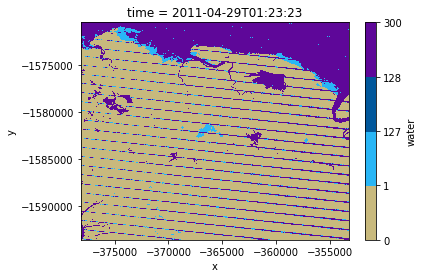

<xarray.DataArray 'water' (y: 925, x: 994)>
array([[132, 132, 132, ..., 132, 132, 132],
       [132, 132, 132, ..., 132, 132, 132],
       [132, 132, 132, ..., 132, 132, 132],
       ..., 
       [128, 130, 130, ..., 131, 131, 131],
       [128, 128, 128, ..., 131, 131, 131],
       [128, 128, 128, ..., 131, 131, 131]], dtype=uint8)
Coordinates:
    time     datetime64[ns] 2011-04-29T01:23:23
  * y        (y) float64 -1.571e+06 -1.571e+06 -1.571e+06 -1.571e+06 ...
  * x        (x) float64 -3.781e+05 -3.781e+05 -3.781e+05 -3.78e+05 ...
Attributes:
    nodata:            1
    units:             1
    crs:               EPSG:3577
    flags_definition:  {'dry': {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0'...


In [19]:
 # open all the shapes within the shape file
if True:
    shapes = fiona.open(shape_file)
    #i is the index of the shape file we have chosen
    i =0 
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
    print(geo)
    print(geom_bs)
    filename=output_file_text.value
    end_of_epoch = to_date_picker.value
    start_of_epoch=from_date_picker.value
    
    #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue',
                         'green',
                         'red',
                         'nir',
                         'swir1',
                         'swir2'
                         ]

    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
    }
     #Create a query to store spatiotemporal information from the previous landsat query
    wofs_query = query
    dcwofs = datacube.Datacube(config='/g/data/r78/dc_configs/wofscube.conf')
    
    wofs_data = dcwofs.load(product = 'wofs_albers', **wofs_query)

    #Concatenate (join) the data from the different WOfS scenes together and sort so that observations are sorted 
    #by time
    import matplotlib as mpl
    wofs_cmap = mpl.colors.ListedColormap(['#C8B97D','#B3E5FC','#81D4FA','#4FC3F7','#29B6F6','#039BE5',
                                       '#0288D1','#0277BD', '#01579B','#1A237E','#02033a','#5e0799'])
    wofs_data.water.isel(time=5).plot(levels=[0, 1,127,128,300],cmap=wofs_cmap)
    plt.show()
    #xr_wofs = xr.DataArray(wofs_data)
    print(wofs_data.water.isel(time=5))
#wofs = load_wofs(query)


In [ ]:
if True:
    shapes = fiona.open(shape_file)
    #i is the index of the shape file we have chosen
    i =0 
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

    filename=output_file_text.value
    end_of_epoch = to_date_picker.value
    start_of_epoch=from_date_picker.value
    
    #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue',
                         'green',
                         'red',
                         'nir',
                         'swir1',
                         'swir2'
                         ]

    
    query = {
        'time': ('1900-01-01', '2017-12-01'), 'geopolygon': geom
    }
    rf=load_rainfall(query)



In [ ]:
start_of_epoch


In [ ]:
rf
rf_average = rf.rainfall.mean(dim =('longitude','latitude'))
rf_mnthy_average = rf_average.resample('1M', dim='time',how='sum')
rf_mnthy_average

In [ ]:
import matplotlib.dates as mdates
#plt.close('all')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax5 = plt.subplots()
ax5.plot(rf_mnthy_average.time,rf_mnthy_average.values)
# format the ticks
#ax5.xaxis.set_major_locator(years)
#ax5.xaxis.set_major_formatter(yearsFmt)
#ax5.xaxis.set_minor_locator(months)
ax5.format_xdata = mdates.DateFormatter('%Y-%m')
            
ax5.set_title('Rainfall\n')
#plt.tight_layout()

plt.show()

In [ ]:
rf_mnthy_average

In [ ]:
end_of_epoch